# This notebook predicts a person's gender with our code

We define a model that can be used to test batchnormalization 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, log_loss
import matplotlib.pyplot as plt

In [2]:
# Data upload 
file_path = "data/voice.csv"  
data = pd.read_csv(file_path)

data['label'] = data['label'].map({'male': 1, 'female': 0})

X = data.drop(columns=['label']).values  
y = data['label'].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X = X_train.T
y = y_train.reshape((1, y_train.shape[0]))

X_test = X_test.T
y_test = y_test.reshape((1, y_test.shape[0]))
y_test = y_test.flatten()

In [3]:
# the parameters for the model
learning_rate = 0.01
hidden_layer = 16 
epoch = 500
batchsize = 64

In [4]:
# Function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_safe(z):
    return np.clip(sigmoid(z), 1e-7, 1 - 1e-7)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

def binary_cross_entropy_derivative(y_true, y_pred):
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + 1e-8)

In [5]:
# first neural network
def initialisation(n0, n1, n2):
    W1 = np.random.randn(n1, n0) * 0.01
    b1 = np.zeros((n1, 1))
    W2 = np.random.randn(n2, n1) * 0.01
    b2 = np.zeros((n2, 1))
    parameter = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return parameter

def forward_propagation(X, parameter):
    W1 = parameter['W1']
    W2 = parameter['W2']
    b1 = parameter['b1']
    b2 = parameter['b2']
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid_safe(Z2)
    activations = {'A1': A1, 'A2': A2}
    return activations

def back_propragation(X, y, parameter, activations):
    A1 = activations['A1']
    A2 = activations['A2']
    W2 = parameter['W2']
    m = y.shape[1]
    dZ2 = A2 - y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(A1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    gradients = {'db1': db1, 'db2': db2, 'dW1': dW1, 'dW2': dW2}
    return gradients

def update(gradients, parameter, learning_rate):
    dW1 = gradients['dW1']
    dW2 = gradients['dW2']
    db1 = gradients['db1']
    db2 = gradients['db2']
    W1 = parameter['W1']
    W2 = parameter['W2']
    b1 = parameter['b1']
    b2 = parameter['b2']
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2
    parameter = {'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}
    return parameter

def predict(X, parameter):
    activations = forward_propagation(X, parameter)
    A2 = activations['A2']
    return (A2 >= 0.5).astype(int)

def predict_proba(X, parameter):
    activations = forward_propagation(X, parameter)
    A2 = activations['A2']
    return A2 

def neural_network(X, y, n1=16, learning_rate=0.1, epochs=50, batch_size=32):
    n0 = X.shape[0]
    n2 = y.shape[0]
    np.random.seed(0)
    parametres = initialisation(n0, n1, n2)
    train_loss = []
    train_acc = []
    
    # Example numbers
    m = X.shape[1]
    
    for epoch in range(epochs):
        epoch_loss = []
        epoch_acc = []
        
        # Mini-batch
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        y_shuffled = y[:, permutation]
        
        # Mini-batch training
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            y_batch = y_shuffled[:, i:i+batch_size]
            
            # Forward pass
            activations = forward_propagation(X_batch, parametres)
            A2 = activations['A2']
            
            # Calculation of the loss
            loss = log_loss(y_batch.flatten(), A2.flatten())
            y_pred = predict(X_batch, parametres)
            acc = accuracy_score(y_batch.flatten(), y_pred.flatten())
            
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            
            # Backward pass
            gradients = back_propragation(X_batch, y_batch, parametres, activations)
            
            # Update of the parameters
            parametres = update(gradients, parametres, learning_rate)
        
        # Calculation of the loss and the metrics accuracy
        train_loss.append(np.mean(epoch_loss))
        train_acc.append(np.mean(epoch_acc))
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.4f}")
    
    # Plot of the train set
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return parametres


In [6]:
def batch_normalization(Z, gamma, beta, epsilon=1e-8):
    mean = np.mean(Z, axis=1, keepdims=True)
    variance = np.var(Z, axis=1, keepdims=True)
    
    # Normalization
    Z_norm = (Z - mean) / np.sqrt(variance + epsilon)
    
    # Linear transformation
    Z_out = gamma * Z_norm + beta
    
    return Z_out, mean, variance, Z_norm

def forward_propagation_BN(X, parameter, gamma1, beta1):
    W1 = parameter['W1']
    W2 = parameter['W2']
    b1 = parameter['b1']
    b2 = parameter['b2']
    Z1 = W1.dot(X) + b1
    
    # Batch Normalization of the hidden layer
    Z1_bn, mean_Z1, var_Z1, Z1_norm = batch_normalization(Z1, gamma1, beta1)
    
    # Activation function after the BN
    A1 = relu(Z1_bn)
    
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid_safe(Z2)
    
    activations = {'A1': A1, 'A2': A2}
    cache = {'mean_Z1': mean_Z1, 'var_Z1': var_Z1, 'Z1_norm': Z1_norm}
    
    return activations, cache

def back_propagation_BN(X, y, parameter, activations, cache, gamma1, beta1):
    A1 = activations['A1']
    A2 = activations['A2']
    W2 = parameter['W2']
    m = y.shape[1]
    
    # back to the 2 hidden layers
    dZ2 = A2 - y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    
    # Backpropagation to the 1 hidden layers
    dA1 = W2.T.dot(dZ2)
    dZ1_bn = dA1 * relu_derivative(A1)
    
    Z1_norm = cache['Z1_norm']
    mean_Z1 = cache['mean_Z1']
    var_Z1 = cache['var_Z1']
    
    m = Z1_norm.shape[1]
    
    # calculation of the gradients
    dZ1 = (1. / m) * gamma1 * (1. / np.sqrt(var_Z1 + 1e-8)) * (
        m * dZ1_bn - np.sum(dZ1_bn, axis=1, keepdims=True) - Z1_norm * np.sum(dZ1_bn * Z1_norm, axis=1, keepdims=True) / (var_Z1 + 1e-8)
    )
    
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    
    dgamma1 = np.sum(dZ1_bn * Z1_norm, axis=1, keepdims=True)
    dbeta1 = np.sum(dZ1_bn, axis=1, keepdims=True)
    
    gradients = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dgamma1': dgamma1, 'dbeta1': dbeta1}
    
    return gradients

def update_BN(gradients, parameter, gamma1, beta1, learning_rate):
    dW1 = gradients['dW1']
    dW2 = gradients['dW2']
    db1 = gradients['db1']
    db2 = gradients['db2']
    W1 = parameter['W1']
    W2 = parameter['W2']
    b1 = parameter['b1']
    b2 = parameter['b2']
    
    # Update of parameters of the network
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2
    
    # Update of the parameters of the BN
    gamma1 = gamma1 - learning_rate * gradients['dgamma1']
    beta1 = beta1 - learning_rate * gradients['dbeta1']
    
    parameter = {'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}
    
    return parameter, gamma1, beta1

gamma1 = np.ones((hidden_layer, 1))
beta1 = np.zeros((hidden_layer, 1))

def predict_BN(X, parameter):
    activations, _ = forward_propagation_BN(X, parameter, gamma1, beta1)
    A2 = activations['A2']
    return (A2 >= 0.5).astype(int)

def predict_BN_proba(X, parameter):
    activations, _ = forward_propagation_BN(X, parameter, gamma1, beta1)
    A2 = activations['A2']
    return A2 


def neural_network_BN(X, y, n1=16, learning_rate=0.1, epochs=50, batch_size=32):
    n0 = X.shape[0]
    n2 = y.shape[0]
    
    np.random.seed(0)
    parametres = initialisation(n0, n1, n2)
    
    # Initialization of the parameters
    gamma1 = np.ones((n1, 1))
    beta1 = np.zeros((n1, 1))
    
    train_loss = []
    train_acc = []
    
    m = X.shape[1]
    
    for epoch in range(epochs):
        epoch_loss = []
        epoch_acc = []
        
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        y_shuffled = y[:, permutation]
        
        # Mini-batch training
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            y_batch = y_shuffled[:, i:i+batch_size]
            
            # Forward pass
            activations, cache = forward_propagation_BN(X_batch, parametres, gamma1, beta1)
            A2 = activations['A2']
            
            loss = log_loss(y_batch.flatten(), A2.flatten())
            y_pred = predict_BN(X_batch, parametres)
            acc = accuracy_score(y_batch.flatten(), y_pred.flatten())
            
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            
            gradients = back_propagation_BN(X_batch, y_batch, parametres, activations, cache, gamma1, beta1)
            
            parametres, gamma1, beta1 = update_BN(gradients, parametres, gamma1, beta1, learning_rate)
        
        train_loss.append(np.mean(epoch_loss))
        train_acc.append(np.mean(epoch_acc))
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return parametres


Epoch 1/500, Loss: 0.6904, Accuracy: 0.4885
Epoch 2/500, Loss: 0.6896, Accuracy: 0.5008
Epoch 3/500, Loss: 0.6901, Accuracy: 0.5117
Epoch 4/500, Loss: 0.6882, Accuracy: 0.5156
Epoch 5/500, Loss: 0.6891, Accuracy: 0.5176
Epoch 6/500, Loss: 0.6889, Accuracy: 0.5173
Epoch 7/500, Loss: 0.6887, Accuracy: 0.5160
Epoch 8/500, Loss: 0.6884, Accuracy: 0.5185
Epoch 9/500, Loss: 0.6865, Accuracy: 0.5228
Epoch 10/500, Loss: 0.6873, Accuracy: 0.5183
Epoch 11/500, Loss: 0.6848, Accuracy: 0.5171
Epoch 12/500, Loss: 0.6866, Accuracy: 0.5147
Epoch 13/500, Loss: 0.6843, Accuracy: 0.5159
Epoch 14/500, Loss: 0.6837, Accuracy: 0.5207
Epoch 15/500, Loss: 0.6858, Accuracy: 0.5172
Epoch 16/500, Loss: 0.6837, Accuracy: 0.5153
Epoch 17/500, Loss: 0.6822, Accuracy: 0.5125
Epoch 18/500, Loss: 0.6830, Accuracy: 0.5109
Epoch 19/500, Loss: 0.6827, Accuracy: 0.5246
Epoch 20/500, Loss: 0.6815, Accuracy: 0.5184
Epoch 21/500, Loss: 0.6839, Accuracy: 0.5147
Epoch 22/500, Loss: 0.6809, Accuracy: 0.5127
Epoch 23/500, Loss:

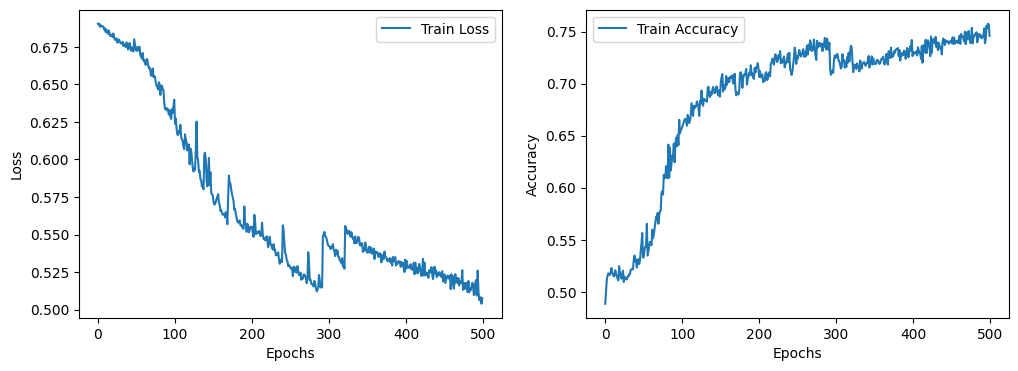

Accuracy: 0.7492
Precision: 0.7697
Recall: 0.7537
F1 Score: 0.7616


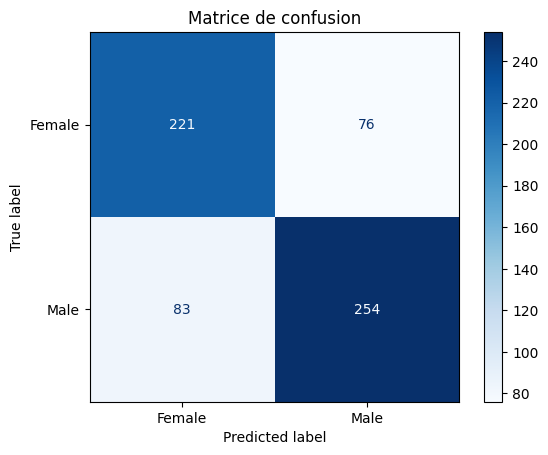

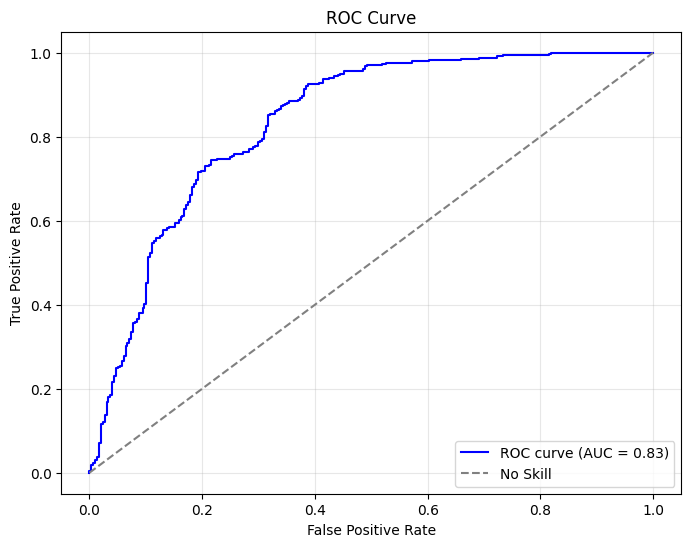

AUC: 0.83
Gini Score: 0.67


In [7]:
parametres_final = neural_network(X, y, n1=hidden_layer, learning_rate=learning_rate, epochs=epoch, batch_size=batchsize)

y_test_pred = predict(X_test, parametres_final)  

accuracy = accuracy_score(y_test, y_test_pred.flatten())
precision = precision_score(y_test, y_test_pred.flatten())
recall = recall_score(y_test, y_test_pred.flatten())
f1 = f1_score(y_test, y_test_pred.flatten())

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_test_pred.flatten())

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
cm_display.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()

y_test_pred_proba = predict_proba(X_test, parametres_final)

y_test_pred_proba = y_test_pred_proba.reshape(y_test_pred_proba.shape[1],1)
# Calculation of the ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

# Calculation of the AUC
auc_score = roc_auc_score(y_test, y_test_pred_proba)

# Calculation of the score GINI
gini_score = 2 * auc_score - 1

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"AUC: {auc_score:.2f}")
print(f"Gini Score: {gini_score:.2f}")

Epoch 1/500, Loss: 0.6921, Accuracy: 0.5142
Epoch 2/500, Loss: 0.6896, Accuracy: 0.5095
Epoch 3/500, Loss: 0.6890, Accuracy: 0.5178
Epoch 4/500, Loss: 0.6889, Accuracy: 0.5179
Epoch 5/500, Loss: 0.6885, Accuracy: 0.5168
Epoch 6/500, Loss: 0.6886, Accuracy: 0.5178
Epoch 7/500, Loss: 0.6893, Accuracy: 0.5185
Epoch 8/500, Loss: 0.6905, Accuracy: 0.5213
Epoch 9/500, Loss: 0.6884, Accuracy: 0.5228
Epoch 10/500, Loss: 0.6892, Accuracy: 0.5243
Epoch 11/500, Loss: 0.6888, Accuracy: 0.5224
Epoch 12/500, Loss: 0.6890, Accuracy: 0.5201
Epoch 13/500, Loss: 0.6894, Accuracy: 0.5202
Epoch 14/500, Loss: 0.6892, Accuracy: 0.5192
Epoch 15/500, Loss: 0.6874, Accuracy: 0.5289
Epoch 16/500, Loss: 0.6875, Accuracy: 0.5246
Epoch 17/500, Loss: 0.6896, Accuracy: 0.5244
Epoch 18/500, Loss: 0.6880, Accuracy: 0.5281
Epoch 19/500, Loss: 0.6877, Accuracy: 0.5219
Epoch 20/500, Loss: 0.6867, Accuracy: 0.5297
Epoch 21/500, Loss: 0.6871, Accuracy: 0.5292
Epoch 22/500, Loss: 0.6878, Accuracy: 0.5277
Epoch 23/500, Loss:

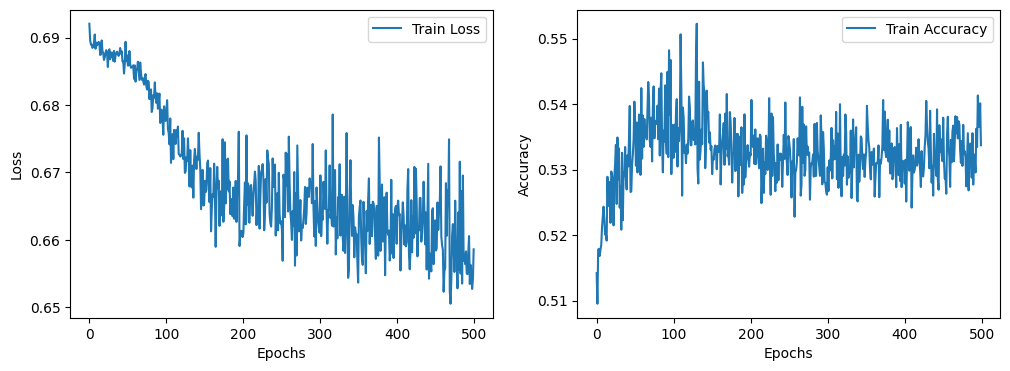

Accuracy: 0.4905
Precision: 0.8500
Recall: 0.0504
F1 Score: 0.0952


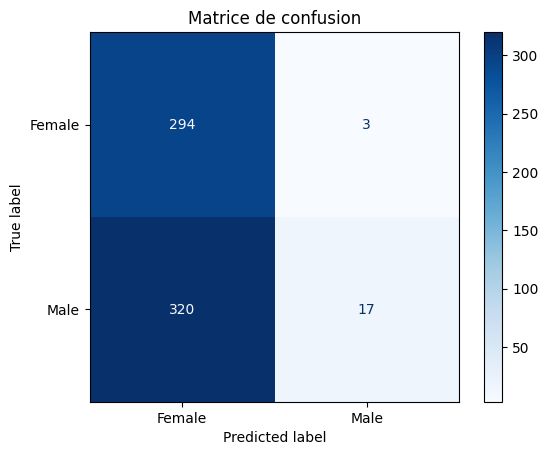

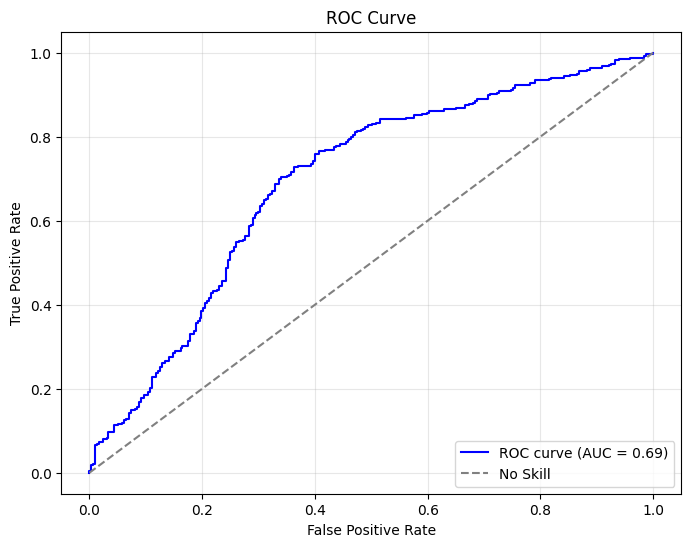

AUC: 0.69
Gini Score: 0.39


In [8]:
parametres_final_BN = neural_network_BN(X, y, n1=hidden_layer, learning_rate=learning_rate, epochs=epoch, batch_size=batchsize)

y_test_pred = predict_BN(X_test, parametres_final_BN)  

accuracy = accuracy_score(y_test, y_test_pred.flatten())
precision = precision_score(y_test, y_test_pred.flatten())
recall = recall_score(y_test, y_test_pred.flatten())
f1 = f1_score(y_test, y_test_pred.flatten())

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_test_pred.flatten())

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
cm_display.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()

y_test_pred_proba = predict_BN_proba(X_test, parametres_final_BN)

y_test_pred_proba = y_test_pred_proba.reshape(y_test_pred_proba.shape[1],1)
# Calculation of the ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

# Calculation of the AUC
auc_score = roc_auc_score(y_test, y_test_pred_proba)

# Calculation of the score GINI
gini_score = 2 * auc_score - 1

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"AUC: {auc_score:.2f}")
print(f"Gini Score: {gini_score:.2f}")